# Imports

In [1]:
import collections
import math
import os
import random
import torch
import matplotlib.pyplot as plt
from torch import nn
import time
import numpy as np
import re

# Sentiment Analysis

## Preprocessing the dataset

In [2]:
def read_imdb(data_dir, is_train):
    data, labels = [], []
    for label in ['pos', 'neg']:
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test', label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'r', encoding='utf-8') as f:
                review = f.read().replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

In [3]:
train_data = read_imdb('aclImdb', True)
print('# training: ', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label: ', y, 'review: ', x[:60])

# training:  25000
label:  1 review:  Bromwell High is a cartoon comedy. It ran at the same time a
label:  1 review:  Homelessness (or Houselessness as George Carlin stated) has 
label:  1 review:  Brilliant over-acting by Lesley Ann Warren. Best dramatic ho


In [4]:
def preprocess(text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        """Defined in :numref:`sec_text-sequence`"""
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']
    
def tokenize(lines, token='word'):
    """Split text lines into word or character tokens.

    Defined in :numref:`sec_text_preprocessing`"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

def build(raw_text, vocab=None):
    tokens = tokenize(preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab


In [5]:
train_tokens = tokenize(train_data[0], token='word')
vocab = Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

(array([ 553., 2373., 6820., 4834., 2817., 1848., 1380., 1005.,  759.,
         581.,  437.,  349.,  257.,  207.,  174.,  133.,  116.,   85.,
          75.]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.,
        550., 600., 650., 700., 750., 800., 850., 900., 950.]),
 <BarContainer object of 19 artists>)

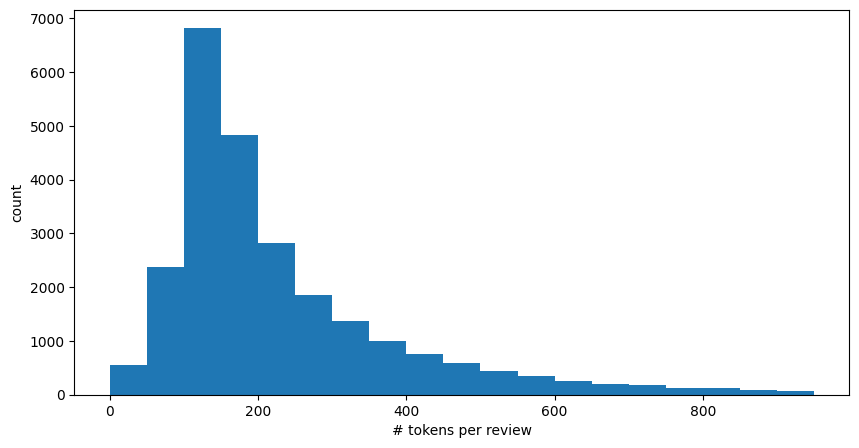

In [6]:
plt.figure(figsize=(10, 5))
plt.xlabel('# tokens per review')
plt.ylabel('count')
plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50))

In [7]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))

In [8]:
#Sequence length
num_steps = 500
train_features = torch.tensor([truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])

In [9]:
print(train_features.shape)

torch.Size([25000, 500])


## Creating Data Iterators

In [10]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [11]:
train_iter = load_array((train_features, torch.tensor(train_data[1])), batch_size=64, is_train=True)

for X, y in train_iter:
    print('X:', X.shape, 'y:', y.shape)
    break
print('# batches: ', len(train_iter))

X: torch.Size([64, 500]) y: torch.Size([64])
# batches:  391


# Putting it all together

In [12]:
def load_data_imdb(batch_size, num_steps=500):
    data_dir = "aclImdb"
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = tokenize(train_data[0], token='word')
    test_tokens = tokenize(test_data[0], token='word')
    vocab = Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = load_array((train_features, torch.tensor(train_data[1])), batch_size, is_train=True)
    test_iter = load_array((test_features, torch.tensor(test_data[1])), batch_size, is_train=False)
    return train_iter, test_iter, vocab

train_iter, test_iter, vocab = load_data_imdb(64, 500)

# Sentiment Analysis Using RNNs

## Representing Single Text with RNNs

In [13]:
class BiRNN(nn.Module):
    def __init__(self, num_hidden, vocab_size, embed_size, num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.LSTM(embed_size, num_hidden, num_layers=num_layers, bidirectional=True)
        self.decoder = nn.Linear(4 * num_hidden, 2)

    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [14]:
num_hidden, embed_size, num_layers = 50, 50, 2
net = BiRNN(num_hidden, len(vocab), embed_size, num_layers)

def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

net.apply(init_weights)

BiRNN(
  (embedding): Embedding(49346, 50)
  (encoder): LSTM(50, 50, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=200, out_features=2, bias=True)
)

## Loading Pretrained Word Vectors

In [15]:
class TokenEmbeddings:
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        with open(embedding_name, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.split(' ')
                if len(parts) > 2:
                    token = parts[0]
                    idx_to_token.append(token)
                    idx_to_vec.append([float(x) for x in parts[1:]])
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        return self.idx_to_vec[torch.tensor(indices)]

    def __len__(self):
        return len(self.idx_to_token)

In [16]:
glove_embedding = TokenEmbeddings('../glove.6B.50d/vec.txt')

In [17]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 50])

In [18]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

## Training and Evaluating the Model

In [19]:
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices):
    """Train a model with multiple GPUs."""
    timer, num_batches = Timer(), len(train_iter)
    animator = Animator()  # Using the custom Animator implementation
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    
    for epoch in range(num_epochs):
        metric = Accumulator(4)  # Using the custom Accumulator
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                train_loss = metric[0] / metric[2]
                train_acc = metric[1] / metric[3]
                animator.add(epoch + (i + 1) / num_batches, 
                           (train_loss, train_acc, None))
        
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    
    print(f'Loss: {metric[0] / metric[2]:.3f}')
    print(f'Train accuracy: {metric[1] / metric[3]:.3f}')
    print(f'Test accuracy: {test_acc:.3f}')
    print(f'Training speed: {metric[2] * num_epochs / timer.sum():.1f} examples/sec')
    print(f'Device(s) used: {str(devices)}')
    
    animator.show()  # Display the training curves

class Timer:
    """Recording multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

class Animator:  # Define a new Animator class that properly handles None values
	def __init__(self, xlabel=None, ylabel=None, legend=None):
		self.data = {'train_loss': [], 'train_acc': [], 'test_acc': []}
		self.epochs = []
		
	def add(self, epoch, metrics):
		self.epochs.append(epoch)
		train_loss, train_acc, test_acc = metrics
		if train_loss is not None:
			self.data['train_loss'].append(float(train_loss))
		if train_acc is not None:
			self.data['train_acc'].append(float(train_acc))
		if test_acc is not None:
			self.data['test_acc'].append(float(test_acc))
			
	def show(self):
		plt.figure(figsize=(10, 6))
		for label, values in self.data.items():
			if values:  # Only plot if we have data
				plt.plot(self.epochs[:len(values)], values, label=label)
		plt.xlabel('Epoch')
		plt.ylabel('Metric Value')
		plt.legend()
		plt.grid(True)
		plt.show()

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [20]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.to(y.dtype) == y
    return float(cmp.sum())

def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU.

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]

size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)

def train_batch_ch13(net, X, y, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs (defined in Chapter 13)."""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

C:\Users\Ishaan\AppData\Local\Temp\ipykernel_16504\4280381105.py:92: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  self.data = [a + float(b) for a, b in zip(self.data, args)]


Loss: 0.344
Train accuracy: 0.849
Test accuracy: 0.840
Training speed: 9451.6 examples/sec
Device(s) used: [device(type='cuda', index=0)]


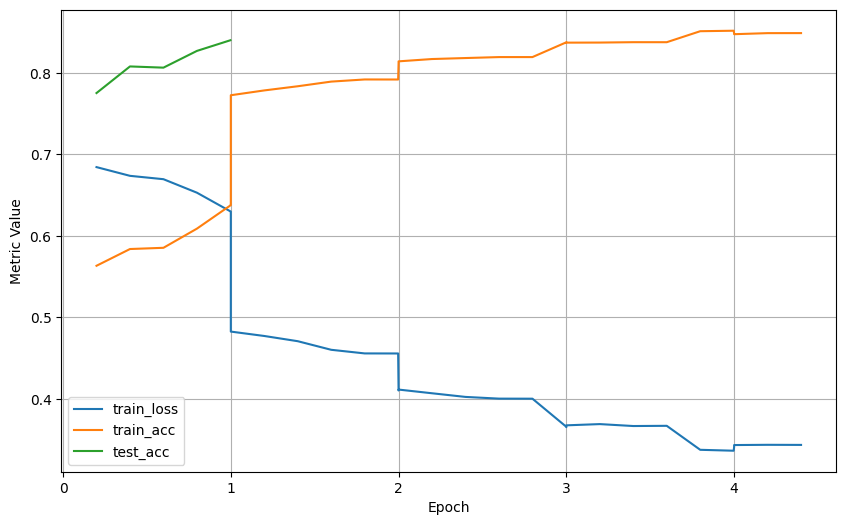

In [21]:
lr, num_epochs, devices = 0.01, 5, [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [22]:
def predict_sentiment(net, vocab, sequence, devices):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=devices[0])
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [23]:
predict_sentiment(net, vocab, 'this movie is so great', devices=devices)


'positive'

In [24]:
predict_sentiment(net, vocab, 'this movie is so bad', devices=devices)


'negative'

# Sentiment Analysis: Using Convolutional Neural Networks

In [25]:
batch_size = 64
train_iter, test_iter, vocab = load_data_imdb(batch_size)

## One-Dimensional Convolutions

In [36]:
def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

In [40]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

When performing this operation on a one-dimensional input with multiple channels, we set a kernel with the same number of channels, perform cross-correlation operations per channel and sum the output across its channels to get a one-dimensional representation

In [41]:
def corr1d_multi_in(X, K):
    return sum(corr1d(x, k) for x, k in zip(X, K))

In [45]:
X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

# The TextCNN Model

In [46]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels
        embeddings = embeddings.permute(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [54]:
embed_size, kernel_sizes, nums_channels = 50, [3, 4, 5], [50, 50, 50]
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)

net.apply(init_weights);

### Loading Pretrained Word Vectors

In [55]:
glove_embedding = TokenEmbeddings('../glove.6B.50d/vec.txt')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

### Training and Evaluating the Model

Loss: 0.086
Train accuracy: 0.972
Test accuracy: 0.877
Training speed: 13606.1 examples/sec
Device(s) used: [device(type='cuda', index=0)]


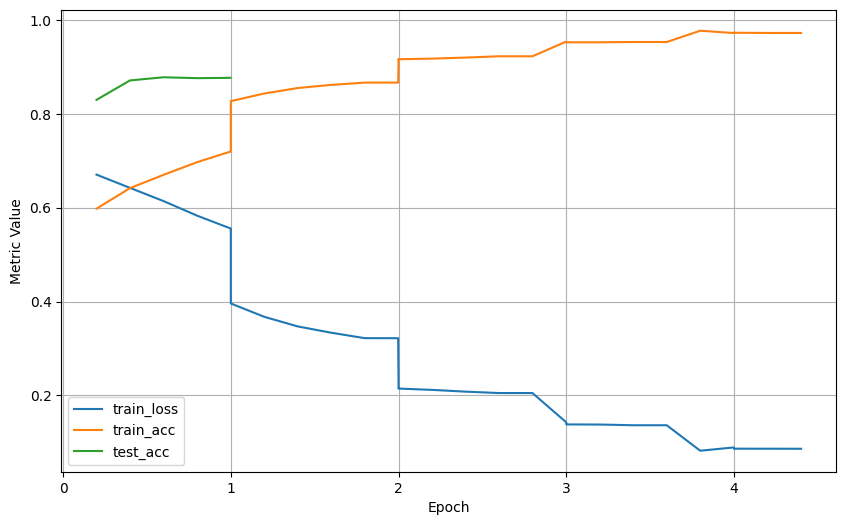

In [56]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [58]:
predict_sentiment(net, vocab, 'this movie is so great', devices=devices)

'positive'

In [59]:
predict_sentiment(net, vocab, 'this movie is so bad', devices=devices)

'negative'

# Natural Language Inference

## Reading the Dataset

In [62]:
data_dir = 'snli_1.0'
def read_snli(data_dir, is_train=False):
    def extract_text(s):
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()
    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt' if is_train else 'snli_1.0_test.txt')
    with open(file_name, 'r') as f:
        rows = [row.split('\t') for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

In [63]:
train_data = read_snli(data_dir, True)
for x0, x1, y in zip(train_data[0][:3], train_data[1][:3], train_data[2][:3]):
    print(f'premise: {x0}')
    print(f'hypothesis: {x1}')
    print(f'label: {y}')

premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is training his horse for a competition .
label: 2
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is at a diner , ordering an omelette .
label: 1
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is outdoors , on a horse .
label: 0


In [64]:
test_data = read_snli(data_dir, is_train=False)
for data in [train_data, test_data]:
    print([[row for row in data[2]].count(i) for i in range(3)])

[183416, 183187, 182764]
[3368, 3237, 3219]


### Defining a class for loading the dataset

In [71]:
class SNLIDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        all_premises_tokens = tokenize(dataset[0])
        all_hypotheses_tokens = tokenize(dataset[1])
        if vocab is None:
            self.vocab = Vocab(all_premises_tokens + all_hypotheses_tokens, min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        self.premises = self._pad(all_premises_tokens)
        self.hypothesis = self._pad(all_hypotheses_tokens)
        self.labels = torch.tensor(dataset[2])
        print(f'read {str(len(self.premises))} examples')

    def _pad(self, lines):
        return torch.tensor([truncate_pad(self.vocab[line], self.num_steps, self.vocab['<pad>']) for line in lines])

    def __getitem__(self, idx):
        return (self.premises[idx], self.hypothesis[idx]), self.labels[idx]

    def __len__(self):
        return len(self.premises)

## Putting It All Together

In [72]:
def load_data_snli(batch_size, num_steps=50, data_dir='snli_1.0'):
    """Download the SNLI dataset and return data iterators and vocabulary."""
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)
    train_set = SNLIDataset(train_data, num_steps)
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                             shuffle=True)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                            shuffle=False)
    return train_iter, test_iter, train_set.vocab

In [73]:
train_iter, test_iter, vocab = load_data_snli(128, 50)
len(vocab)

read 549367 examples
read 9824 examples


18678

In [74]:
for X, Y in train_iter:
    print(X[0].shape)
    print(X[1].shape)
    print(Y.shape)
    break

torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128])
